<a href="https://colab.research.google.com/github/ykim68ncstate/ST-554-Project1/blob/main/Task2/Project_1_Task_2_David_Pressley.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1 - On Field Calibration of Electronic Nose for Benzene Estimation

## Introduction
Low cost gas sensors used in urban air pollution monitoring facet two key problems:


1.   *Specificity* Available sensors are unable to distinguish between gases well
2.   *Drift*: Solid-state sensors measurements drift making their quantitative measurements unreliable over time, due to:
*   intrinsic physical and chemical properties
*   environmental temperature fluctuations
*   exposure to the environment
*   oxidation of the sensor surface

The manufacturer specifies less than 2% drift per 6 months (DeVito, 2008)

## Background
This dataset comes from the UC Irvine Machine Learning repository and contains the reponses of a gas multisensor device deployed in a field in a polluted area in an Italian city. Data were captured from March 2004 to February 2005 (one year), and represent the longest freely available recordings of air quality sensor device measurements.

### Dataset Characteristics

**Collection Context**:
- **Location**: Road-level sensor in a significantly polluted urban area in Italy
- **Duration**: March 2004 to February 2005 (12 months)
- **Instances**: 9,358 hourly averaged observations
- **Device**: Air Quality Chemical Multisensor Device with 5 metal oxide sensors

**Variable Types**:

| Type | Variables | Source |
|------|-----------|--------|
| Ground truth (GT) | CO(GT), NMHC(GT), C6H6(GT), NOx(GT), NO2(GT) | Co-located certified reference analyzer |
| Sensor responses | PT08.S1(CO), PT08.S2(NMHC), PT08.S3(NOx), PT08.S4(NO2), PT08.S5(O3) | Metal oxide sensor array |
| Environmental | T (temperature), RH (relative humidity), AH (absolute humidity) | Weather measurements |

**Data Quality Issues**:
- **Missing values**: Tagged with `-200` (not NaN). These will be replaced with NaN but not removed for intermediate dataset creation to retain complete integrity and veracity of the dataset.
- **Cross-sensitivities**: Sensors respond to multiple gases, not just their target analyte
- **Concept drift**: Underlying pollutant mixture composition changes seasonally (e.g., winter heating increases NOx)
- **Sensor drift**: Baseline resistance changes over the 12-month deployment period

### EDA Analysis Plan

**Univariate summary of C6H6(GT)**
- .describe(), histogram, box plot. Document skewness, range, outliers.
**Correlation investigation**
- .corr() of variables (benzene + 5 non-GT sensors + 3 weather). Discuss which variables are strongly/weakly correlated with benzene.
**Numeric summaries at different levels**
- bin (e.g. temperature into quartiles using pd.qcut(), or a sensor variable)
- show benzene summaries within those groups via .groupby()
**Bivariate plots**
- Scatter plots of benzene against key sensors and weather variables. Use a loop or plt.subplots() to avoid repeating code (GPP/DRY). Discuss what the relationships look like
**Temporal analysis**
- include both "over time" and "ignoring time."
- For over time: line plot of benzene over date
    - create categorical and datetimevalues
- For ignoring time: see scatter/correlation work.
     - at minimum get a time series line plot in.

**Usage Restrictions**: Research purposes only; commercial use fully excluded. Citation of De Vito et al., Sens. And Act. B, Vol. 129, 2, 2008 required.




## Task 2 - Exploratory Data Analysis

### Data Import and Description

In [127]:
# import Colab base imports
from pprint import pprint
from IPython.display import HTML, display, Markdown
import pandas as pd
import numpy as np
from datetime import date, datetime
import matplotlib.pyplot as plt

# import ucimlrepo
try:
    # import ucimlrepo
    from ucimlrepo import fetch_ucirepo
    print(f"{datetime.today()}: ucimlrepo is already installed.")
except ImportError:
    print(f"{datetime.today()}: ucimlrepo not found. Installing now...")
    !pip install ucimlrepo -q
    print(f"{datetime.today()}: ucimlrepo installed.")


# load pandas as data table for quality of life
from google.colab import data_table
data_table.enable_dataframe_formatter()

# fetch dataset
air_quality_raw = fetch_ucirepo(id=360)

#check the type of each value in the top-level keys
print("Types of top-level values:")
for key in air_quality_raw.keys():
    # get object type, then access its __name__
    print(f"  {key}: {type(air_quality_raw[key]).__name__}")

# Step 2: 'data' is source data. Get keys
if hasattr(air_quality_raw['data'], 'keys'):
    display(Markdown(f"### Keys inside 'data': `{air_quality_raw['data'].keys()}`"))

# convert raw data dictionaries to dataframes.
# ML convention is to store independent vars as features, and any output vars as targets. Targets is empty.
raw_features = air_quality_raw.data.features
display(Markdown(f"### Source (Raw) DataFrame is: `raw_features`   \n \tData Type: {type(raw_features).__name__}.  Use as baseline dataset for subsequent analysis \n\n"))


# describe data
# type is dict <class 'ucimlrepo.dotdict.dotdict'>, so get keys
# print(f"Raw Data Type: {type(air_quality_raw)}")

#keys
raw_keys = [key for key in air_quality_raw.keys()]
display(Markdown(f"### Raw Data Dictionary Keys: {raw_keys}"))

#get variables
# variable information
# Select only the columns 'name', 'type', 'units', 'description'
vars_summary = air_quality_raw.variables[['name', 'type', 'units', 'description']]

# convert dtypes Series to a DataFrame and rename columns
# reset_index creates a column named `index`, and is renamed to `name` for merging below
vars_dtypes = air_quality_raw.data.features.dtypes.reset_index()
vars_dtypes.columns = ['name', 'dtype']

# create variable summary for reference
vars_summary = pd.merge(vars_summary, vars_dtypes, on='name', how='left')
vars_summary = vars_summary[['name', 'type', 'dtype', 'units', 'description']]

# set index to 1 for quick reference of variable count
vars_summary.index += 1
# display(Markdown(vars_summary.to_markdown(index=True)))

# copy these to a Text cell for reference
# get var name metadata
# print((vars_summary.to_markdown(index=True)))
display(Markdown(f"### Raw Dataset Variable Metadata: \n"))
display(vars_summary)

# get data head
# display(Markdown(f"##  Data Head"))
display(Markdown(f"### Raw Dataset Head: \n"))
display((air_quality_raw.data.features.head()))

2026-02-22 03:44:35.816394: ucimlrepo is already installed.


## Raw Dataset Variable Metadata
|    | name          | type        | dtype   | units      | description                                                                                            |
|---:|:--------------|:------------|:--------|:-----------|:-------------------------------------------------------------------------------------------------------|
|  1 | Date          | Date        | object  |            |                                                                                                        |
|  2 | Time          | Categorical | object  |            |                                                                                                        |
|  3 | CO(GT)        | Integer     | float64 | mg/m^3     | True hourly averaged concentration CO in mg/m^3  (reference analyzer)                                  |
|  4 | PT08.S1(CO)   | Categorical | int64   |            | hourly averaged sensor response (nominally  CO targeted)                                               |
|  5 | NMHC(GT)      | Integer     | int64   | microg/m^3 | True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer) |
|  6 | C6H6(GT)      | Continuous  | float64 | microg/m^3 | True hourly averaged Benzene concentration  in microg/m^3 (reference analyzer)                         |
|  7 | PT08.S2(NMHC) | Categorical | int64   |            | hourly averaged sensor response (nominally NMHC targeted)                                              |
|  8 | NOx(GT)       | Integer     | int64   | ppb        | True hourly averaged NOx concentration  in ppb (reference analyzer)                                    |
|  9 | PT08.S3(NOx)  | Categorical | int64   |            | hourly averaged sensor response (nominally NOx targeted)                                               |
| 10 | NO2(GT)       | Integer     | int64   | microg/m^3 | True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)                              |
| 11 | PT08.S4(NO2)  | Categorical | int64   |            | hourly averaged sensor response (nominally NO2 targeted)                                               |
| 12 | PT08.S5(O3)   | Categorical | int64   |            | hourly averaged sensor response (nominally O3 targeted)                                                |
| 13 | T             | Continuous  | float64 | °C         | Temperature                                                                                            |
| 14 | RH            | Continuous  | float64 | %          | Relative Humidity                                                                                      |
| 15 | AH            | Continuous  | float64 |            | Absolute Humidity                                                                                      |



## Raw Dataset Head
| Date      | Time     |   CO(GT) |   PT08.S1(CO) |   NMHC(GT) |   C6H6(GT) |   PT08.S2(NMHC) |   NOx(GT) |   PT08.S3(NOx) |   NO2(GT) |   PT08.S4(NO2) |   PT08.S5(O3) |    T |   RH |     AH |
|:----------|:---------|---------:|--------------:|-----------:|-----------:|----------------:|----------:|---------------:|----------:|---------------:|--------------:|-----:|-----:|-------:|
| 3/10/2004 | 18:00:00 |      2.6 |          1360 |        150 |       11.9 |            1046 |       166 |           1056 |       113 |           1692 |          1268 | 13.6 | 48.9 | 0.7578 |
| 3/10/2004 | 19:00:00 |      2   |          1292 |        112 |        9.4 |             955 |       103 |           1174 |        92 |           1559 |           972 | 13.3 | 47.7 | 0.7255 |
| 3/10/2004 | 20:00:00 |      2.2 |          1402 |         88 |        9   |             939 |       131 |           1140 |       114 |           1555 |          1074 | 11.9 | 54   | 0.7502 |
| 3/10/2004 | 21:00:00 |      2.2 |          1376 |         80 |        9.2 |             948 |       172 |           1092 |       122 |           1584 |          1203 | 11   | 60   | 0.7867 |
| 3/10/2004 | 22:00:00 |      1.6 |          1272 |         51 |        6.5 |             836 |       131 |           1205 |       116 |           1490 |          1110 | 11.2 | 59.6 | 0.7888 |


## Data Cleaning
Data cleaning will be performed on the full dataset before narrowing down features, so that it will be easy to include other Ground Truth sensor variables if needed in the `raw_features` dataset

### Missing values Analysis

#### Handling Missing Values

Based on UCIML repo information, sensor values of `-200` are invalid. We will replace the `-200` placeholder values with `NaN` to properly handle missing data.

In [48]:
# create a new dataframe for feature manipulation
features_clean_df = raw_features.copy()

# Missing values analysis before replacement
# replace -200 with NaN across the features_clean_df DataFrame
display(Markdown(f"### Action: Replacing -200 values with NaN in features_clean_df DataFrame"))
features_clean_df.replace(-200, np.nan, inplace=True);


# Missing values analysis after replacement
# Calculate counts and percentages
column_metadata = pd.DataFrame({
    'name': features_clean_df.columns,
    'total_count': len(features_clean_df),
    'ok_sensor_count': features_clean_df.count(),
    'bad_sensor_count': features_clean_df.isnull().sum(),
    'missing_percentage': (features_clean_df.isnull().sum() / len(features_clean_df)) * 100
})

# Select and reorder columns
column_metadata = column_metadata[['name', 'bad_sensor_count', 'ok_sensor_count', 'missing_percentage', 'total_count']]
display(Markdown((f"### DataFrame containing column metadata after replacing -200 values with NaN:")))
display(Markdown(column_metadata.to_markdown(index=False)))

### Action: Replacing -200 values with NaN in features_clean_df DataFrame

### DataFrame containing column metadata after replacing -200 values with NaN:

| name          |   bad_sensor_count |   ok_sensor_count |   missing_percentage |   total_count |
|:--------------|-------------------:|------------------:|---------------------:|--------------:|
| Date          |                  0 |              9357 |              0       |          9357 |
| Time          |                  0 |              9357 |              0       |          9357 |
| CO(GT)        |               1683 |              7674 |             17.9865  |          9357 |
| PT08.S1(CO)   |                366 |              8991 |              3.91151 |          9357 |
| NMHC(GT)      |               8443 |               914 |             90.2319  |          9357 |
| C6H6(GT)      |                366 |              8991 |              3.91151 |          9357 |
| PT08.S2(NMHC) |                366 |              8991 |              3.91151 |          9357 |
| NOx(GT)       |               1639 |              7718 |             17.5163  |          9357 |
| PT08.S3(NOx)  |                366 |              8991 |              3.91151 |          9357 |
| NO2(GT)       |               1642 |              7715 |             17.5484  |          9357 |
| PT08.S4(NO2)  |                366 |              8991 |              3.91151 |          9357 |
| PT08.S5(O3)   |                366 |              8991 |              3.91151 |          9357 |
| T             |                366 |              8991 |              3.91151 |          9357 |
| RH            |                366 |              8991 |              3.91151 |          9357 |
| AH            |                366 |              8991 |              3.91151 |          9357 |

### Date and Time Transformation

The `Date` and `Time` columns are stored as strings. Combining them into a single `datetime` column and setting it as the index enables more efficient pandas time series operations like `.resample()`.

**Note**  No additional timing variables will be included in this analysis dataset. Since the index is a datetime object, subsequent analysis level needs that require timing variables should be created from the index as required by the analysis.

We will also verify that each datetime provides uniqueness to the record.

In [49]:
# combine Date and Time into a datetime column
features_clean_df["datetime"] = pd.to_datetime(
    features_clean_df["Date"] + " " + features_clean_df["Time"],
    format="%m/%d/%Y %H:%M:%S"
)


# drop original Date and Time columns
# set as index and drop original string columns
features_clean_df = features_clean_df.set_index("datetime")
# check dtype of the index
print(f"Datetime index dtype: {features_clean_df.index.dtype}")



if len(pd.unique(features_clean_df.index)) == len(pd.unique(features_clean_df.index)):
    print(f"Index contains unique values: \n index: {len(pd.unique(features_clean_df.index))} \n records:{len(features_clean_df)} ")
else:
    print("Index contains duplicate values")

print(f"Date range: {features_clean_df.index.min()} to {features_clean_df.index.max()}")
features_clean_df.head()



Datetime index dtype: datetime64[ns]
Index contains unique values: 
 index: 9357 
 records:9357 
Date range: 2004-03-10 18:00:00 to 2005-04-04 14:00:00


### Data Subsetting

Per the project requirements, we will include:
- Unique key / Index variable:
    - `datetime`: contains one record per hour
- Timing variables:
    - `Date`
    - `Time`
- **Response variable**: `C6H6(GT)` (benzene GT: Ground Truth, microg/m^3)
- **Sensor variables**: `PT08.S1(CO)`, `PT08.S2(NMHC)`, `PT08.S3(NOx)`, `PT08.S4(NO2)`, `PT08.S5(O3)`
- **Weather variables**: `T` (temperature), `RH` (relative humidity), `AH` (absolute humidity)

Exclude the other ground truth columns (`CO(GT)`, `NMHC(GT)`, `NOx(GT)`, `NO2(GT)`) per requirements

In [50]:
keep = ["C6H6(GT)",
        "PT08.S1(CO)",
        "PT08.S2(NMHC)",
        "PT08.S3(NOx)",
        "PT08.S4(NO2)",
        "PT08.S5(O3)",
        "T",
        "RH",
        "AH"]

benzene_analysis_df = features_clean_df[keep].copy()
print((f"Subset shape: {benzene_analysis_df.shape}"))
print((f"Columns: {benzene_analysis_df.columns}"))

zero_rows = benzene_analysis_df[benzene_analysis_df['C6H6(GT)'] == 0]
print(f"Count of rows with C6H6(GT) == 0: {len(zero_rows)}")

# check for NaN values using .isnull() and .any()
# This will return True if there is at least one NaN value in the 'C6H6(GT)' column.
nan_rows = benzene_analysis_df[benzene_analysis_df['C6H6(GT)'].isna()]
print(f"Count of NaN values in C6H6(GT) column: {len(nan_rows)}")

display(benzene_analysis_df.head())

Subset shape: (9357, 9)
Columns: Index(['C6H6(GT)', 'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)',
       'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH'],
      dtype='object')
Count of rows with C6H6(GT) == 0: 0
Count of NaN values in C6H6(GT) column: 366


,C6H6(GT),PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
datetime,,,,,,,,,
2004-03-10 18:00:00,11.9,1360.0,1046.0,1056.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,9.4,1292.0,955.0,1174.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,9.0,1402.0,939.0,1140.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,9.2,1376.0,948.0,1092.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,6.5,1272.0,836.0,1205.0,1490.0,1110.0,11.2,59.6,0.7888


### Dropping rows with Missing Benzene

In [51]:
n_before = len(benzene_analysis_df)
print(f"Rows before: {n_before}")
benzene_analysis_df = benzene_analysis_df.dropna(subset=['C6H6(GT)'])
n_after = len(benzene_analysis_df)
print(f"Rows after: {n_after}")
print(f"Rows dropped: {n_before - n_after}")

Rows before: 9357
Rows after: 8991
Rows dropped: 366


### Data Grouping References
A little bit of housecleaning since the variables are challenging to type
We will create a named variable grouping for easy reference in subsequent DataFrame manipulations, similar to ENVIRONMENT_VARIABLES

- `benzene_col` = `["C6H6(GT)"]`
- `sensor_cols` = `["PT08.S1(CO)", "PT08.S2(NMHC)", "PT08.S3(NOx)", "PT08.S4(NO2)", "PT08.S5(O3)"]`
- `weather_cols` = `["T", "RH", "AH"]`

In [52]:
target_col = "C6H6(GT)"
sensor_cols = ["PT08.S1(CO)", "PT08.S2(NMHC)", "PT08.S3(NOx)",
               "PT08.S4(NO2)", "PT08.S5(O3)"]
weather_cols = ["T", "RH", "AH"]

print(f"Target Column: {target_col}")
print(f"Sensor Columns: {[x for x in sensor_cols]}")
print(f"Weather Columns: {[x for x in weather_cols]}")

Target Column: C6H6(GT)
Sensor Columns: ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']
Weather Columns: ['T', 'RH', 'AH']


### Post Cleaning Summary

The analysis dataset `benzene_analysis_df` contains hourly observations spanning March 2004 to February 2005, with 9 numeric variables: benzene concentration, five sensor responses, and three weather measurements.

**DataFrame summary:**
- `raw_features` : original as-fetched, never modified
- `features_clean_df` : working copy with NaN replacement and datetime index
- `benzene_analysis_df` : final analysis subset(9 columns, no missing benzene: removed 366 rows of NaN benzene values)


In [53]:
print(benzene_analysis_df.info())
display(benzene_analysis_df.head())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8991 entries, 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   C6H6(GT)       8991 non-null   float64
 1   PT08.S1(CO)    8991 non-null   float64
 2   PT08.S2(NMHC)  8991 non-null   float64
 3   PT08.S3(NOx)   8991 non-null   float64
 4   PT08.S4(NO2)   8991 non-null   float64
 5   PT08.S5(O3)    8991 non-null   float64
 6   T              8991 non-null   float64
 7   RH             8991 non-null   float64
 8   AH             8991 non-null   float64
dtypes: float64(9)
memory usage: 702.4 KB
None


,C6H6(GT),PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
datetime,,,,,,,,,
2004-03-10 18:00:00,11.9,1360.0,1046.0,1056.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,9.4,1292.0,955.0,1174.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,9.0,1402.0,939.0,1140.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,9.2,1376.0,948.0,1092.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,6.5,1272.0,836.0,1205.0,1490.0,1110.0,11.2,59.6,0.7888


---
## Section 2: Univariate Analysis of Benzene Concentration

We need to understand the distribution of our primary variable of interest: `C6H6(GT)`, the ground truth benzene concentration measured in micrograms per cubic meter (microg/m^3).


In [54]:

print("Descriptive Statistics for Benzene:")
print(benzene_analysis_df[target_col].describe())

print(f"\nSkewness: {benzene_analysis_df[target_col].skew().round(3)}")
print(f"\nKurtosis: {benzene_analysis_df[target_col].kurtosis().round(3)}")


Descriptive Statistics for Benzene:
count    8991.000000
mean       10.083105
std         7.449820
min         0.100000
25%         4.400000
50%         8.200000
75%        14.000000
max        63.700000
Name: C6H6(GT), dtype: float64

Skewness: 1.362

Kurtosis: 2.489


Discussion: The mean benzene concentration is higher than the median, which along with the positive skewness value confirms a right-skewed distribution, consistent with what we might expect from pollution events. Most readings are moderate, but sometimes move higher due to weather events, higher seasonal values, etc.


### Benzene Histogram

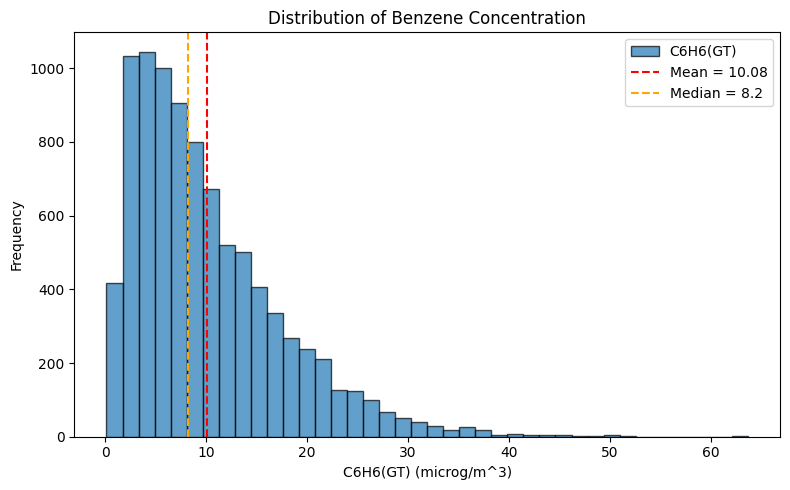

In [55]:
# histogram of benzene concentration
plt.subplots(figsize=(8, 5))
benzene_analysis_df[target_col].plot.hist(bins=40, edgecolor="black", alpha=0.7)
plt.axvline(benzene_analysis_df[target_col].mean(), color="red", linestyle="--",
            label=f"Mean = {round(benzene_analysis_df[target_col].mean(), 2)}")
plt.axvline(benzene_analysis_df[target_col].median(), color="orange", linestyle="--",
            label=f"Median = {round(benzene_analysis_df[target_col].median(), 2)}")
plt.xlabel("C6H6(GT) (microg/m^3)")
plt.ylabel("Frequency")
plt.title("Distribution of Benzene Concentration")
plt.legend()
plt.tight_layout()
plt.show()

**Discussion:** The histogram confirms the right-skewed shape. Most benzene readings are clustered below 15 microg/m^3, with a long tail extending to higher values. The red dashed line (mean) sits to the right of the orange dashed line (median), visually confirming the positive right skew.

Benzene Boxplot

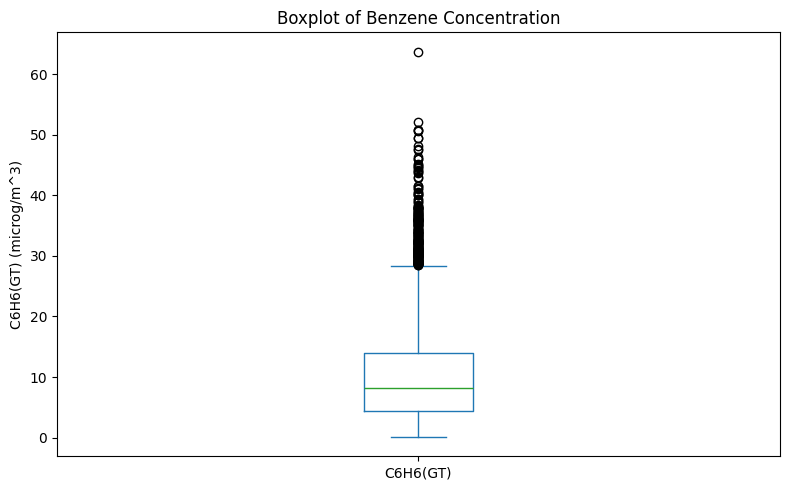

In [56]:
# boxplot of benzene concentration
plt.subplots(figsize=(8, 5))
benzene_analysis_df[target_col].plot.box()
plt.ylabel("C6H6(GT) (microg/m^3)")
plt.title("Boxplot of Benzene Concentration")
plt.tight_layout()
plt.show()

---
## Section 3: Numeric Summaries by Time Period

Air quality varies with both human activity patterns (time of day, day of week) and seasonal factors (temperature, heating demand). We examine benzene concentrations grouped by different time dimensions.

### Boxplots of Benzene values by time catetories

Time Dimension Summaries:
day_of_week
month
year
season


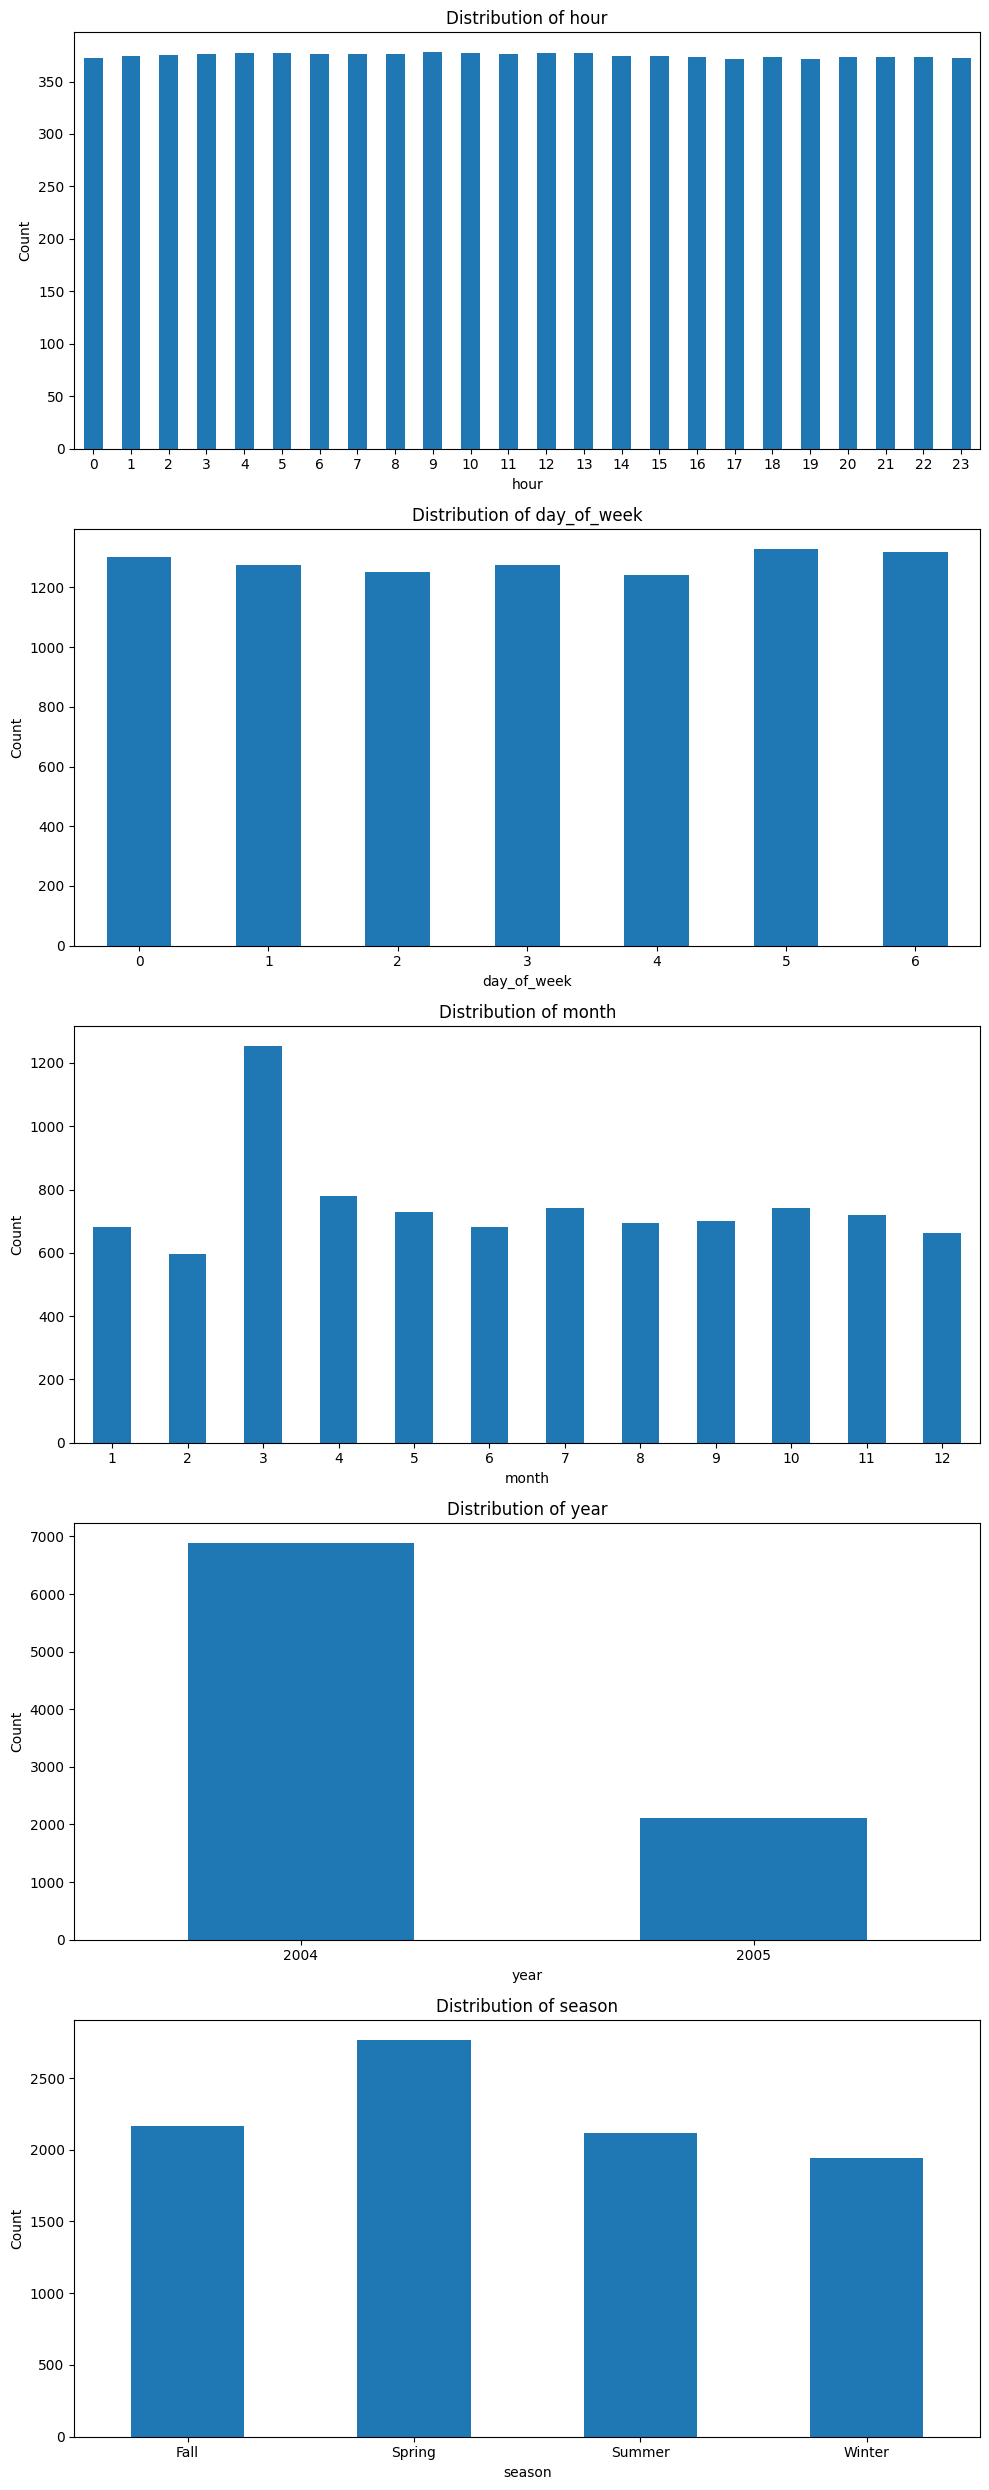

In [57]:
# create seasonal variable
def get_season(month):
    if month in [12,1,2]:
        return "Winter"
    elif month in [3,4,5]:
        return "Spring"
    elif month in [6,7,8]:
        return "Summer"
    else:
        return "Fall"


benzene_analysis_df["hour"] = benzene_analysis_df.index.hour
benzene_analysis_df["day_of_week"] = benzene_analysis_df.index.dayofweek
benzene_analysis_df["month"] = benzene_analysis_df.index.month
benzene_analysis_df["year"] = benzene_analysis_df.index.year
benzene_analysis_df["season"] = benzene_analysis_df["month"].apply(get_season)

print("Time Dimension Summaries:")
benzene_analysis_df[["hour", "day_of_week", "month", "year", "season"]].describe()

# TODO: implement a function, just to say you can
def bars_by_time(df, *time_categories):
    """
    Generates bar plots for specified time categories from a DataFrame.

    Args:
        df: pandas.DataFrame
        *time_categories: list of column names to plot.
    """

    # plt.subplots(figsize=(8, 5))
    for category in time_categories:
        print(category)

    return None

# bar plots by time periods
time_cols = ["hour", "day_of_week", "month", "year", "season"]
bars_by_time(*time_cols)
# fig is an outer container or canvas for a plot
# axes is the plot container. it has lines, bars, points, x/y labels, title
fig, axes = plt.subplots(nrows=len(time_cols), ncols=1, figsize=(10, 5 * len(time_cols)))
#
axes = axes.flatten()

for i, col in enumerate(time_cols):
    # Added 'color' argument to plot.bar()
    benzene_analysis_df[col].value_counts().sort_index().plot.bar(ax=axes[i], title=f'Distribution of {col}', rot=0)
    axes[i].set_ylabel('Count')
plt.tight_layout()
plt.show()

### Benzene by Hour of Day

In [58]:
# mean benzene concentration by hour of day
hourly_mean = benzene_analysis_df.groupby("hour")[target_col].mean()
print(f"Mean Benzene Concentration by Hour of Day:")
print(hourly_mean.round(2))
hourly_mean.index = hourly_mean.index.map(lambda x: f"{x}:00")
hourly_mean

Mean Benzene Concentration by Hour of Day:
hour
0      7.68
1      5.99
2      4.38
3      3.38
4      2.92
5      3.07
6      4.76
7     10.40
8     15.89
9     14.76
10    12.24
11    11.02
12    10.82
13    10.98
14    10.32
15    10.27
16    11.12
17    13.94
18    16.64
19    17.74
20    15.38
21    11.09
22     8.98
23     8.41
Name: C6H6(GT), dtype: float64


,C6H6(GT)
hour,
0:00,7.684140
1:00,5.991711
2:00,4.379467
3:00,3.379255
4:00,2.916711
5:00,3.068435
6:00,4.756117
7:00,10.398936
8:00,15.894149


Text(0.5, 1.0, 'Mean Benzene Concentration by Hour of Day')

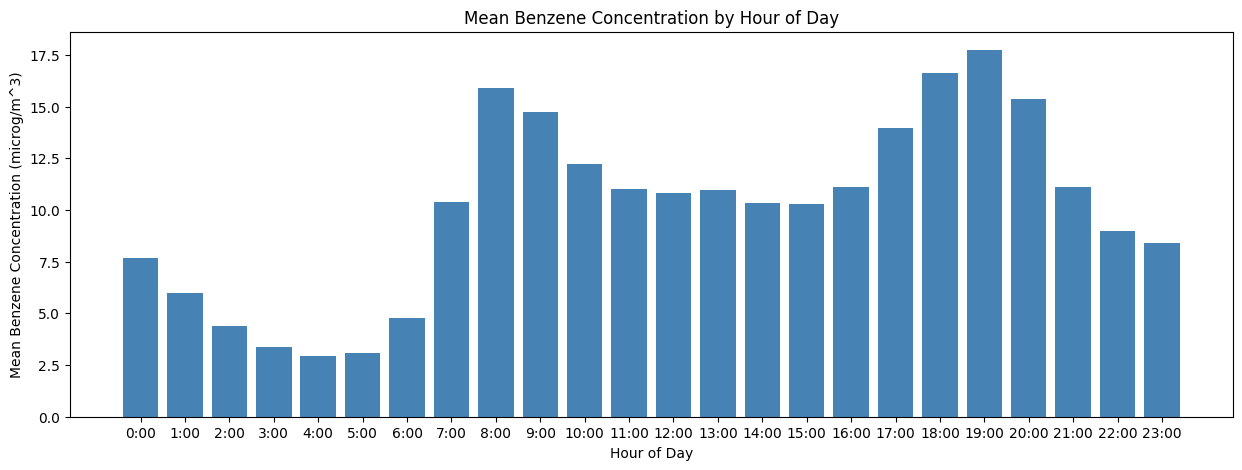

In [59]:
plt.subplots(figsize=(15, 5))
plt.bar(hourly_mean.index, hourly_mean.values, color='steelblue')
plt.xlabel("Hour of Day")
plt.ylabel("Mean Benzene Concentration (microg/m^3)")
plt.title("Mean Benzene Concentration by Hour of Day")

**Discussion:** There is a clear daily pattern in benzene concentration. Levels are highest during evening rush hours and lowest in the early morning. This bimodal pattern is consistent with benzene's primary urban source being vehicle exhaust. Morning and evening traffic surges both drive concentrations up. The afternoon dip occurs when traffic is lighter.

### Benzene by Season

In [87]:
# summary stats by season
season_order = ["Winter", "Spring", "Summer", "Fall"]
season_summary = benzene_analysis_df.groupby("season")[target_col].describe()
display(Markdown("#### Benzene Concentration Summary by Season"))
season_summary

#### Benzene Concentration Summary by Season

,count,mean,std,min,25%,50%,75%,max
season,,,,,,,,
Fall,2165.0,12.549238,9.060336,0.2,5.5,10.3,17.8,63.7
Spring,2763.0,9.621535,7.012331,0.2,4.1,8.1,13.4,40.3
Summer,2120.0,9.416179,5.938500,0.5,5.0,8.1,12.7,37.3
Winter,1943.0,8.719249,6.899488,0.1,3.5,6.8,12.5,50.8


['Winter', 'Spring', 'Summer', 'Fall']


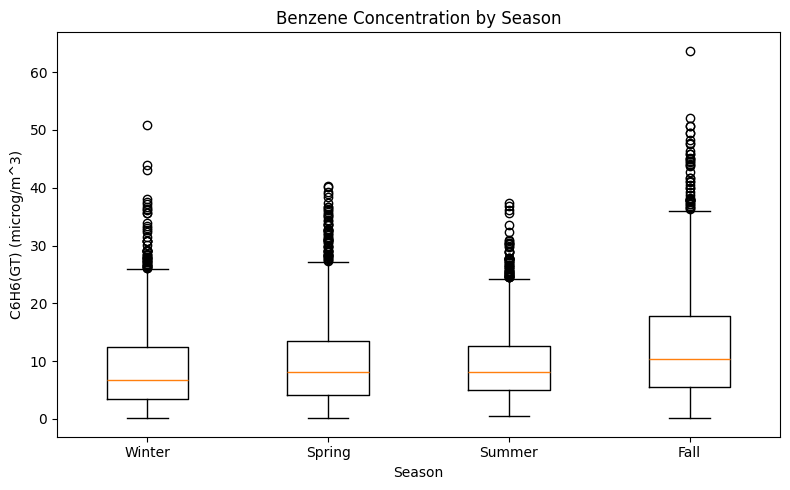

,count,mean,std,min,25%,50%,75%,max
season,,,,,,,,
Fall,2165.0,12.549238,9.060336,0.2,5.5,10.3,17.8,63.7
Spring,2763.0,9.621535,7.012331,0.2,4.1,8.1,13.4,40.3
Summer,2120.0,9.416179,5.938500,0.5,5.0,8.1,12.7,37.3
Winter,1943.0,8.719249,6.899488,0.1,3.5,6.8,12.5,50.8


In [89]:
# boxplots of benzene by season
season_data = [benzene_analysis_df[benzene_analysis_df["season"] == s]
[target_col].dropna()
               for s in season_order]
print(season_order)
plt.subplots(figsize=(8, 5))
plt.boxplot(season_data, tick_labels=season_order)
plt.xlabel("Season")
plt.ylabel("C6H6(GT) (microg/m^3)")
plt.title("Benzene Concentration by Season")
plt.tight_layout()
plt.show()

display(benzene_analysis_df.groupby("season")[target_col].describe())

### Hourly Profiles by Season

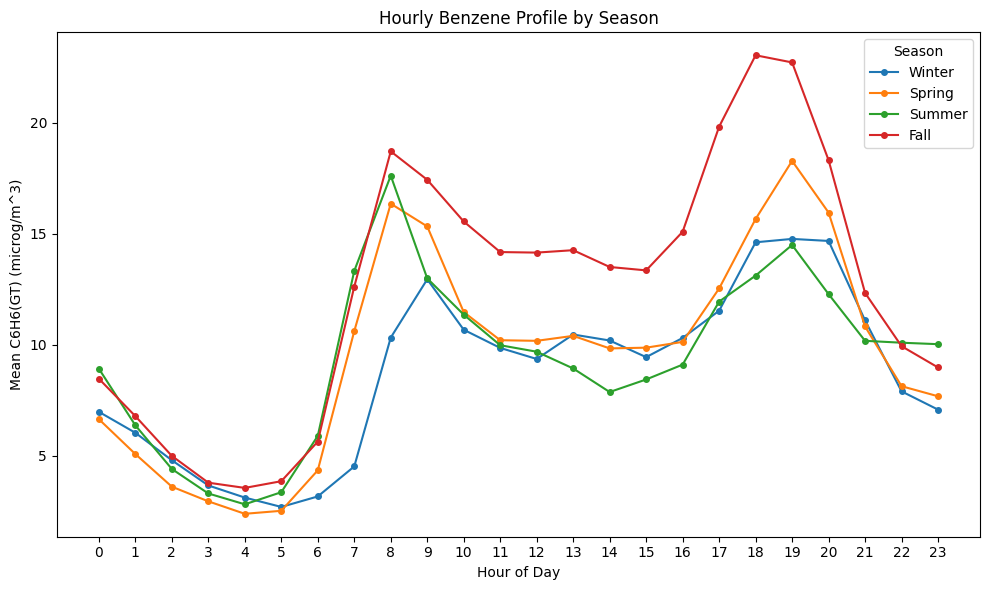

In [90]:
# hourly benzene profiles separated by season
plt.subplots(figsize=(10, 6))
for season in season_order:
    season_hourly = benzene_analysis_df[benzene_analysis_df["season"] == season].groupby("hour")[target_col].mean()
    plt.plot(season_hourly.index, season_hourly.values,
             marker="o", markersize=4, label=season)

plt.xlabel("Hour of Day")
plt.ylabel("Mean C6H6(GT) (microg/m^3)")
plt.title("Hourly Benzene Profile by Season")
plt.legend(title="Season")
plt.xticks(range(24))
plt.tight_layout()
plt.show()

**Discussion:** Benzene concentrations show a relatively consistent seasonal pattern. Fall has the highest median and the most extreme outliers, while summer has the lowest concentrations, however, this pattern is unremarkable. The deployment of the sensors occured in the February/March timeframe, so it may be plausible that the variability observed around the Fall season is due to the known sensor drift that occurs at roughly month 6 after deployment. Other possibilities may include:

2. **Atmospheric stability**: As temperatures drop in fall, temperature inversions become more frequent, trapping pollutants near ground level
3. **Reduced photochemical breakdown**: Shorter daylight hours and weaker UV radiation in fall may slow the photochemical reactions that break down benzene in summer

Winter shows a slightly lower median than fall perhaps because winter weather patterns (wind, precipitation) provide some pollutant dispersion that offsets the increased emissions.

Hourly profiles separated by season show that the diurnal pattern persists across all seasons but is amplified in fall and winter. The rush hour peaks are much more pronounced in cold months than in summer.

**Question**: What direction are the sensor drifts? Higher?

### Benzene by Month

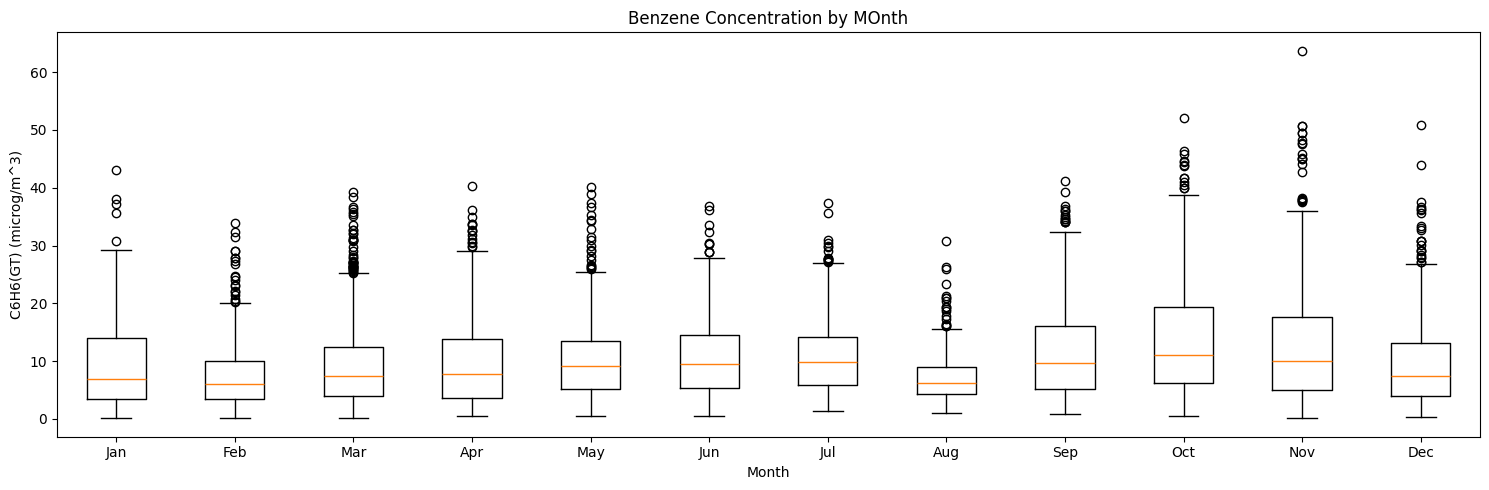

In [85]:
# benzene boxplot by month
month_data = [benzene_analysis_df[benzene_analysis_df["month"] == m] [target_col].dropna() for m in range(1, 13)]

month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
                "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

plt.subplots(figsize=(15, 5))
plt.boxplot(month_data, tick_labels=month_labels)
plt.xlabel("Month")
plt.ylabel("C6H6(GT) (microg/m^3)")
plt.title("Benzene Concentration by MOnth")
plt.tight_layout()
plt.show()



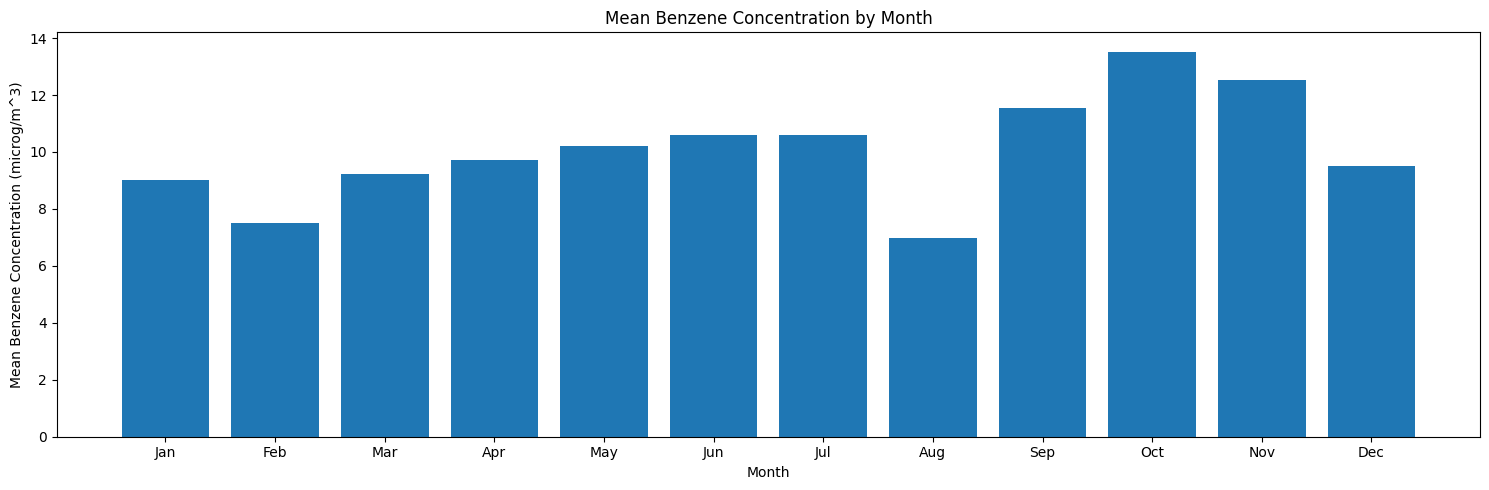

In [76]:
# monthly average benzene
monthly_mean = benzene_analysis_df.groupby("month")[target_col].mean()

month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
                "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

# month_labels is zero-indexed, but month in the lambda func is 1 -12. [month -1] aligns with zero-based indexing
monthly_mean.index = monthly_mean.index.map(lambda month: month_labels[month - 1])

plt.subplots(figsize=(15, 5))
plt.bar(monthly_mean.index, monthly_mean)
plt.xlabel("Month")
plt.ylabel("Mean Benzene Concentration (microg/m^3)")
plt.title("Mean Benzene Concentration by Month")
plt.tight_layout()
plt.show()

**Discussion:** The monthly view provides one level deeper resolution of the seasonal pattern. The lowest benzene concentrations occur during summer months (June-August), with concentrations climbing through the fall months. This provides another level of evidence of sensor drift.

---
## Section 4: Correlation Analysis

We now examine the linear relationships between benzene concentration and the sensor and weather variables. The Pearson correlation coefficient measures the strength and direction of these linear associations.

In [92]:
# correlation matrix for the analysis columns
analysis_cols = [target_col] + sensor_cols + weather_cols
corr_matrix = benzene_analysis_df[analysis_cols].corr()

print("Correlation Matrix:")
display(corr_matrix.round(3))

Correlation Matrix:


,C6H6(GT),PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
C6H6(GT),1.000,0.884,0.982,-0.736,0.766,0.866,0.199,-0.062,0.168
PT08.S1(CO),0.884,1.000,0.893,-0.772,0.683,0.899,0.049,0.115,0.135
PT08.S2(NMHC),0.982,0.893,1.000,-0.797,0.777,0.881,0.241,-0.090,0.187
PT08.S3(NOx),-0.736,-0.772,-0.797,1.000,-0.538,-0.797,-0.145,-0.057,-0.232
PT08.S4(NO2),0.766,0.683,0.777,-0.538,1.000,0.591,0.561,-0.032,0.630
PT08.S5(O3),0.866,0.899,0.881,-0.797,0.591,1.000,-0.027,0.125,0.071
T,0.199,0.049,0.241,-0.145,0.561,-0.027,1.000,-0.579,0.656
RH,-0.062,0.115,-0.090,-0.057,-0.032,0.125,-0.579,1.000,0.168
AH,0.168,0.135,0.187,-0.232,0.630,0.071,0.656,0.168,1.000


In [98]:
# correlation with benzene, sorted by absolute value
benzene_corr = corr_matrix[target_col].abs().sort_values(ascending=False)
benzene_corr_sorted = benzene_corr.sort_values(ascending=False)
print("Correlation with Benzene, Sorted by Absolute Value:")
print(benzene_corr_sorted.round(3))

Correlation with Benzene, Sorted by Absolute Value:
C6H6(GT)         1.000
PT08.S2(NMHC)    0.982
PT08.S1(CO)      0.884
PT08.S5(O3)      0.866
PT08.S4(NO2)     0.766
PT08.S3(NOx)     0.736
T                0.199
AH               0.168
RH               0.062
Name: C6H6(GT), dtype: float64


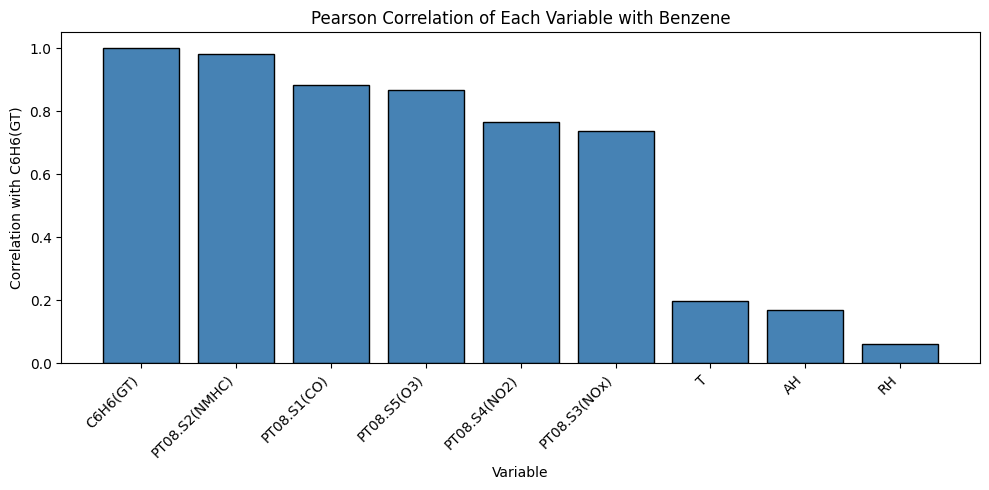

In [99]:
# bar plot of correlations with benzene
colors = ["steelblue" if v > 0 else "salmon" for v in benzene_corr_sorted.values]

plt.subplots(figsize=(10, 5))
plt.bar(range(len(benzene_corr_sorted)),
        benzene_corr_sorted.values,
        color=colors, edgecolor="black")
plt.xticks(range(len(benzene_corr_sorted)),
           benzene_corr_sorted.index, rotation=45, ha="right")
plt.xlabel("Variable")
plt.ylabel("Correlation with C6H6(GT)")
plt.title("Pearson Correlation of Each Variable with Benzene")
plt.axhline(y=0, color="black", linewidth=0.5)
plt.tight_layout()
plt.show()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8991 entries, 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   C6H6(GT)       8991 non-null   float64
 1   PT08.S1(CO)    8991 non-null   float64
 2   PT08.S2(NMHC)  8991 non-null   float64
 3   PT08.S3(NOx)   8991 non-null   float64
 4   PT08.S4(NO2)   8991 non-null   float64
 5   PT08.S5(O3)    8991 non-null   float64
 6   T              8991 non-null   float64
 7   RH             8991 non-null   float64
 8   AH             8991 non-null   float64
 9   hour           8991 non-null   int32  
 10  day_of_week    8991 non-null   int32  
 11  month          8991 non-null   int32  
 12  year           8991 non-null   int32  
 13  season         8991 non-null   object 
dtypes: float64(9), int32(4), object(1)
memory usage: 913.1+ KB
i: 0: col: C6H6(GT)
i: 1: col: PT08.S1(CO)
i: 2: col: PT08.S2(NMHC)
i: 3: col: PT08.S3(NO

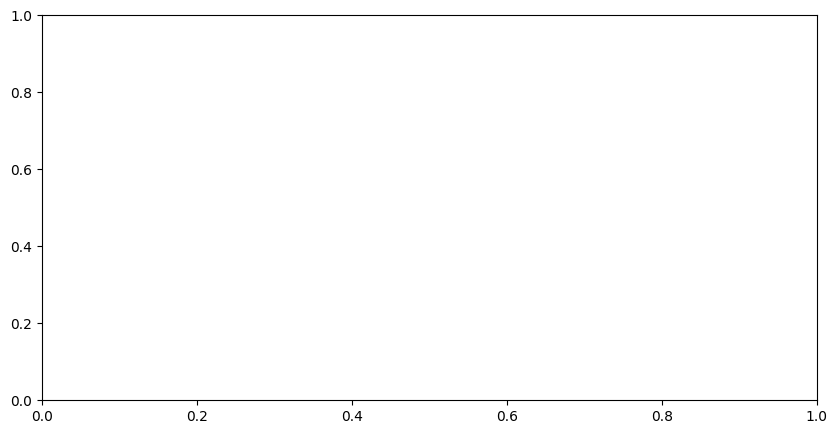

In [136]:
analysis_cols = [target_col] + sensor_cols + weather_cols
plt.subplots(figsize=(10, 5))
benzene_analysis_df.info()
for i, col in enumerate(analysis_cols):
    print(f"i: {i}: col: {col}")
    # plt.scatter_matrix(i, col)
# plt.show()